#Data

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import matplotlib.dates as mdates
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

In [ ]:
#CSV
df_raw = pd.read_csv('https://raw.github.com/IvaMate/data/dfadc96519536379e56452b4d9cc1ee95f660ed3/room_301_9y.csv',sep=',')

#Drop null values
df_raw = df_raw.drop(df_raw.index[df_raw['Set_temp'] == 0.0])
df_raw = df_raw.drop(df_raw.index[df_raw['Room_temp'] == 0.0])

#DATETIME
start='2018-12-03 00:00:00'
end='2018-12-13 23:55:00'
start_test='2018-12-14 00:00:00'
end_test='2018-12-19 23:55:00'

In [ ]:
#Check
df_check=df_raw
df_check.set_index('Datetime',inplace=True)
s='2018-12-01 08:00:00'
e='2018-12-03 08:00:00'
mask = (df_check.index >= s) & (df_check.index <= e)
df_check.loc[mask]

,Set_temp,Room_temp,Hvac_state,Fan_speed,Valve,Room_occupation,Window,Hvac_mode,Humidity,Outside_temp,Irradiation
Datetime,,,,,,,,,,,
2018-12-01 08:00:00,23.0,22.0,1.0,1.0,1.0,1.0,0.0,Heating,84.00,-2.20,10.00
2018-12-01 08:05:00,23.0,22.0,1.0,1.0,1.0,1.0,0.0,Heating,83.92,-2.18,11.67
2018-12-01 08:10:00,23.0,22.0,1.0,1.0,1.0,1.0,0.0,Heating,83.83,-2.17,13.33
2018-12-01 08:15:00,23.0,22.0,1.0,1.0,1.0,1.0,0.0,Heating,83.75,-2.15,15.00
2018-12-01 08:20:00,23.0,22.0,1.0,1.0,1.0,1.0,0.0,Heating,83.67,-2.13,16.67
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-03 07:40:00,21.0,20.0,1.0,0.0,1.0,0.0,0.0,Heating,83.33,6.73,10.67
2018-12-03 07:45:00,21.0,20.0,1.0,0.0,1.0,0.0,0.0,Heating,83.25,6.80,12.00
2018-12-03 07:50:00,21.0,20.0,1.0,0.0,1.0,0.0,0.0,Heating,83.17,6.87,13.33


#Features

In [ ]:
#GROUPS
#G1: 'Time_type', 'is_weekday'
#G2: 'Humidity', 'Outside_temp'
#G3: 'Irradiation'
#G4: 'Set_temp', 'Room_occupation'
#G5: 'Window', 'Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h'

#SVR-A - ALL
all=['Set_temp','Time_type', 'is_weekday', 'Humidity', 'Outside_temp', 'Irradiation', 'Window','Room_occupation','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']
cat=['Time_type', 'is_weekday','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h','Window','Room_occupation']
con=['Set_temp', 'Humidity', 'Outside_temp', 'Irradiation']

#SVR-B
#-G1: 'Time_type', 'is_weekday'
#all=['Set_temp', 'Humidity', 'Outside_temp', 'Irradiation', 'Window','Room_occupation','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']
#cat=['Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h','Window','Room_occupation']
#con=['Set_temp', 'Humidity', 'Outside_temp', 'Irradiation']

#SVR-C
#-G2
#all=['Set_temp','Time_type', 'is_weekday', 'Irradiation', 'Window','Room_occupation','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']
#cat=['Time_type', 'is_weekday','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h','Window','Room_occupation']
#con=['Set_temp', 'Irradiation']

#SVR-D
#-G3
#all=['Set_temp','Time_type', 'is_weekday', 'Humidity', 'Outside_temp', 'Window','Room_occupation','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']
#cat=['Time_type', 'is_weekday','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h','Window','Room_occupation']
#con=['Set_temp', 'Humidity', 'Outside_temp']

#SVR-3
#-G4
#all=['Time_type', 'is_weekday', 'Humidity', 'Outside_temp', 'Irradiation', 'Window','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']
#cat=['Time_type', 'is_weekday','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h','Window']
#con=[ 'Humidity', 'Outside_temp', 'Irradiation']

#SVR-F
#-G5
#all=['Set_temp','Time_type', 'is_weekday', 'Humidity', 'Outside_temp', 'Irradiation','Room_occupation']
#cat=['Time_type', 'is_weekday','Room_occupation']
#con=['Set_temp', 'Humidity', 'Outside_temp', 'Irradiation']

#SVR-VALIDATION
#Include G2, G3, G4
#all=['Set_temp', 'Humidity', 'Outside_temp', 'Irradiation', 'Room_occupation']
#cat=['Room_occupation']
#con=['Set_temp', 'Humidity', 'Outside_temp', 'Irradiation']

##Feature engineering

###is_weekday

In [ ]:
df_raw.Datetime = pd.to_datetime(df_raw.Datetime)
df_raw.dtypes

Datetime           datetime64[ns]
Set_temp                  float64
Room_temp                 float64
Hvac_state                float64
Fan_speed                 float64
Valve                     float64
Room_occupation           float64
Window                    float64
Hvac_mode                  object
Humidity                  float64
Outside_temp              float64
Irradiation               float64
dtype: object

In [ ]:
#df_raw['day_of_week'] = df_raw.index.dt.dayofweek
df_raw.Datetime = pd.to_datetime(df_raw.Datetime)
df_raw['is_weekday'] = (df_raw.Datetime.dt.dayofweek < 5).astype(int)
df_raw

,Datetime,Set_temp,Room_temp,Hvac_state,Fan_speed,Valve,Room_occupation,Window,Hvac_mode,Humidity,Outside_temp,Irradiation,is_weekday
1,2018-12-01 00:05:00,22.0,21.0,1.0,1.0,1.0,0.0,0.0,Heating,79.33,-2.73,0.0,0
2,2018-12-01 00:10:00,22.0,21.0,1.0,1.0,1.0,0.0,0.0,Heating,79.67,-2.77,0.0,0
3,2018-12-01 00:15:00,22.0,21.0,1.0,1.0,1.0,0.0,0.0,Heating,80.00,-2.80,0.0,0
4,2018-12-01 00:20:00,22.0,21.0,1.0,1.0,1.0,0.0,0.0,Heating,80.33,-2.83,0.0,0
5,2018-12-01 00:25:00,22.0,21.0,1.0,1.0,1.0,0.0,0.0,Heating,80.67,-2.87,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,2018-12-31 23:35:00,24.0,23.0,1.0,0.0,0.0,0.0,0.0,Heating,72.17,1.74,0.0,1
8924,2018-12-31 23:40:00,24.0,23.0,1.0,0.0,0.0,0.0,0.0,Heating,72.33,1.73,0.0,1
8925,2018-12-31 23:45:00,24.0,23.0,1.0,0.0,0.0,0.0,0.0,Heating,72.50,1.72,0.0,1
8926,2018-12-31 23:50:00,24.0,23.0,1.0,0.0,0.0,0.0,0.0,Heating,72.67,1.72,0.0,1


In [ ]:
import datetime as dt

df_raw['day_of_week'] = df_raw.Datetime.dt.dayofweek
#one-hot-encoder

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df_raw[['day_of_week']]).toarray(), columns=['Mon', 'Tue', 'Wed', 'Thir', 'Fri', 'Sat', 'Sun'])
#merge with original DataFrame
df = df_raw.join(encoder_df)

In [ ]:
df['Tue'] = df['Tue'].fillna(0)
df['Wed'] = df['Wed'].fillna(0)
df['Thir'] = df['Thir'].fillna(0)
df['Fri'] = df['Fri'].fillna(0)
df['Sat'] = df['Sat'].fillna(0)
df['Sun'] = df['Sun'].fillna(0)
df.loc[(df['Datetime'] >= '2018-12-31 23:45:00') & (df['Datetime'] <= '2018-12-31 23:55:00'), 'Mon'] = 1
df.loc[(df['Datetime'] >= '2018-12-31 23:45:00')]

,Datetime,Set_temp,Room_temp,Hvac_state,Fan_speed,Valve,Room_occupation,Window,Hvac_mode,Humidity,...,Irradiation,is_weekday,day_of_week,Mon,Tue,Wed,Thir,Fri,Sat,Sun
1970-01-01 00:00:00.000008925,2018-12-31 23:45:00,24.0,23.0,1.0,0.0,0.0,0.0,0.0,Heating,72.50,...,0.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.000008926,2018-12-31 23:50:00,24.0,23.0,1.0,0.0,0.0,0.0,0.0,Heating,72.67,...,0.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.000008927,2018-12-31 23:55:00,24.0,23.0,1.0,0.0,0.0,0.0,0.0,Heating,72.83,...,0.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#is_weekday, is_workday
df['is_weekday'] = 0
df.loc[(df['Sat'] == 1.0) | (df['Sun'] == 1.0), 'is_weekday'] = 1
df['is_workday'] = 0
df.loc[(df['is_weekday'] == 0), 'is_workday'] = 1

### Time_type

In [ ]:
df.Datetime = pd.to_datetime(df.Datetime)
df['hour'] = pd.to_datetime(df['Datetime']).dt.hour
df['Morning'] = 0
df['Noon'] = 0
df['Night'] = 0
df.loc[(df['hour'] >= 5) & (df['hour'] <=12), 'Morning'] = 1
df.loc[(df['hour'] > 12) & (df['hour'] <=20), 'Noon'] = 1
df.loc[(df['hour'] >= 0) & (df['hour'] <5) | (df['hour'] > 20) & (df['hour'] <=23), 'Night'] = 1

df['Time_type']=0
df.loc[(df['Morning'] >= 1), 'Time_type'] = 1
df.loc[(df['Noon'] >= 1) , 'Time_type'] = 0.5
df.loc[(df['Night'] >= 1), 'Time_type'] = 0

###Fan_speed_o, Fan_speed_l,Fan_speed_m,Fan_speed_h

In [ ]:
#fan_speed 0,1,2,3 -> binarne vrijednosti
df['Fan_speed_o'] = 0
df.loc[(df['Fan_speed'] == 0), 'Fan_speed_o'] = 1
df['Fan_speed_l'] = 0
df.loc[(df['Fan_speed'] == 1), 'Fan_speed_l'] = 1
df['Fan_speed_m'] = 0
df.loc[(df['Fan_speed'] == 2), 'Fan_speed_m'] = 1
df['Fan_speed_h'] = 0
df.loc[(df['Fan_speed'] == 3), 'Fan_speed_h'] = 1

In [ ]:
dff=df[['Morning','Noon','Night','is_weekday','is_workday','Set_temp',  'Humidity', 'Outside_temp', 'Irradiation', 'Window','Room_occupation','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']]

#Split data

In [ ]:
df_train = df.loc[(df['Datetime'] >= start) & (df['Datetime'] <= end)]
df_test = df.loc[(df['Datetime'] >= start_test) & (df['Datetime'] <= end_test)]

x_train = df_train[all]
x_test = df_test[all]

y_train = df_train[['Room_temp']]
y_test = df_test[['Room_temp']] # actual temp values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3167, 12) (1728, 12) (3167, 1) (1728, 1)


#Standardization

In [ ]:
#FOR STANDARDIZATION
#categorical
cat_x_train=x_train[cat]
cat_x_test=x_test[cat]
#continuous
con_x_train= x_train[con]
con_x_test= x_test[con]

In [ ]:
sc_x_tr = StandardScaler()
x_tr_s = sc_x_tr.fit_transform(con_x_train)

sc_x_te = StandardScaler()
x_te_s = sc_x_te.fit_transform(con_x_test)

sc_y_tr = StandardScaler()
y_train_s = sc_y_tr.fit_transform(y_train)

sc_y_te = StandardScaler()
y_test_s = sc_y_te.fit_transform(y_test)

In [78]:
#######TRAIN
#to df
cont_df_train = pd.DataFrame(x_tr_s, columns=con)
#to df
cat_x_train.reset_index(drop=True, inplace=True)  # Use drop=True to reset the index without keeping the old index as a column
x_train_s_df = pd.concat([cont_df_train, cat_x_train], axis=1)
#to array
x_train_s = x_train_s_df.to_numpy()

#######TEST
#to df
cont_df_test = pd.DataFrame(x_te_s, columns=con)
#merge
cat_x_test.reset_index(drop=True, inplace=True)  # Use drop=True to reset the index without keeping the old index as a column
x_test_s_df = pd.concat([cont_df_test, cat_x_test], axis=1)
#to array
x_test_s = x_test_s_df.to_numpy()

#SVR

SVR, kernel = 'rbf' \
cross validation 10 folds

In [79]:
#optimization
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

y_train_s = np.ravel(y_train_s)
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions, n_iter=10, verbose=2, cv=10, random_state=None)
rnd_search_cv.fit(x_train_s, y_train_s)

#Optimized
y_pred_optimized = rnd_search_cv.best_estimator_.predict(x_test_s)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.4s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.4s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.4s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.4s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.4s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.4s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.4s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.6s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.8s
[CV] END ....C=4.426087677213597, gamma=0.014405001636052444; total time=   0.8s
[CV] END ....C=7.900941804008623, gamma=0.001818406868341512; total time=   0.7s
[CV] END ....C=7.900941804008623, gamma=0.0018

In [80]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([0.43763134, 0.40801139, 0.37365568, 0.53584921, 0.52488048,
        0.41086786, 0.45965784, 0.36001565, 0.40726793, 0.42085397]),
 'std_fit_time': array([0.12963819, 0.09635316, 0.01979399, 0.24327054, 0.18333127,
        0.09389   , 0.13497378, 0.0141218 , 0.12505743, 0.12463083]),
 'mean_score_time': array([0.05793974, 0.04741807, 0.03473525, 0.07471356, 0.06019297,
        0.03448372, 0.05174532, 0.035537  , 0.04699893, 0.04579189]),
 'std_score_time': array([0.01946098, 0.01300646, 0.00227351, 0.04614678, 0.0188376 ,
        0.01164506, 0.01959169, 0.00379715, 0.01920216, 0.01508511]),
 'param_C': masked_array(data=[4.426087677213597, 7.900941804008623,
                    7.941662823825427, 10.046866627214856,
                    10.423165585560028, 7.498341476629541,
                    9.705152036278976, 6.463063926706212,
                    3.9267317636437595, 3.8136002759086356],
              mask=[False, False, False, False, False, False, False, Fal

#Results

In [ ]:
y_pred_optimized

array([ 0.12930711,  0.1139498 ,  0.11266812, ..., -0.39407076,
       -0.40263594, -0.41119222])

In [ ]:
#Metrics
print("MAE:",metrics.mean_absolute_error(y_test_s, y_pred_optimized))
print("MSE:", metrics.mean_squared_error(y_test_s, y_pred_optimized))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test_s, y_pred_optimized)))
print("RSE:", relative_squared_error(y_test_s, y_pred_optimized))
print("R-Squared:", metrics.r2_score(y_test_s,y_pred_optimized))
print("MAPE:", MAPE(y_test_s, y_pred_optimized))

MAE: 0.6466974685895387
MSE: 0.5959144111068312
RMSE: 0.7719549281576167
RSE: 2542.1721063457026
R-Squared: 0.4040855888931688
MAPE: 132.13606530197066


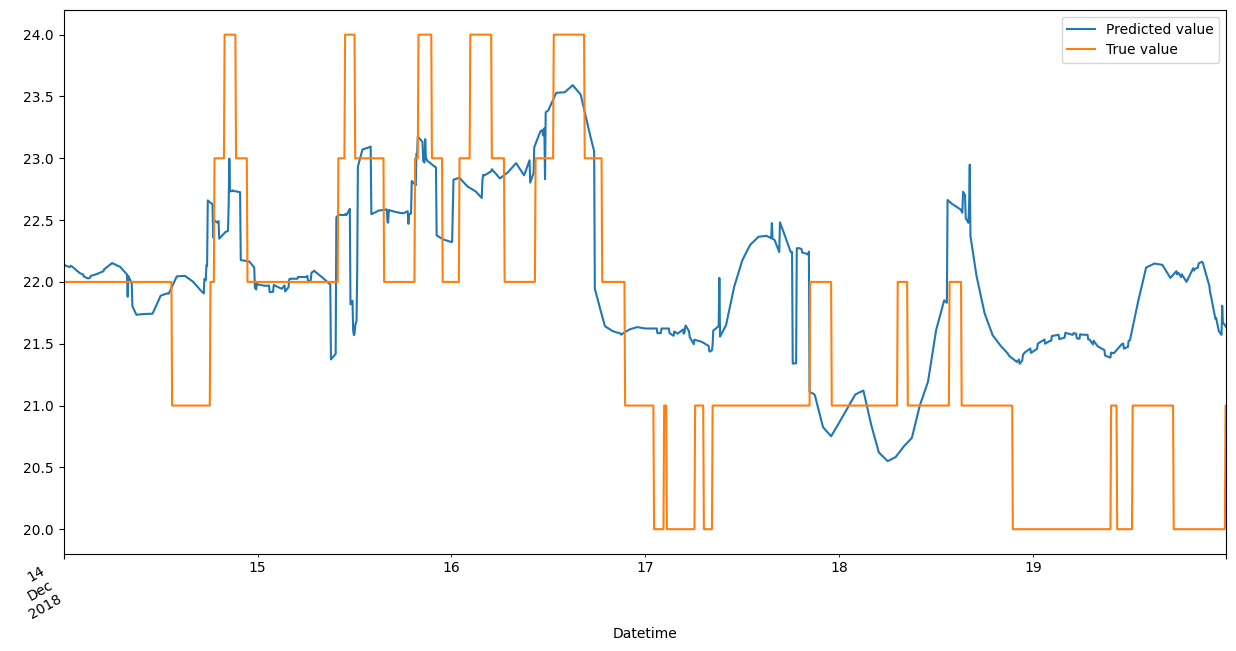

In [ ]:
#Visualization

#2D array
array=[y_pred_optimized]
y_new_inverse = StandardScaler().fit(y_train).inverse_transform(array)
#1D array
array_1d=y_new_inverse.flatten()
df_pred = pd.DataFrame(array_1d, columns = ['y'])
#merge data with datetime
Datetime=df_test['Datetime']
D=Datetime.to_frame()
#Reset index and drop
D = D.reset_index()
D=D.drop(['index'], axis=1)
B=df_test[['Room_temp']]
B = B.reset_index()
B=B.drop(['index'], axis=1)
A=df_pred
A = A.reset_index()
A=A.drop(['index'], axis=1)
#A1
A1=pd.concat([D, A], axis=1)
A1=A1.set_index('Datetime')
#B1
B1=pd.concat([D, B], axis=1)
B1=B1.set_index('Datetime')
#final
df_merged_eval = A1.join(B1)
#visualize
plt.rcParams["figure.figsize"] = (15,8)
ax = df_merged_eval.plot()
plt.gcf().autofmt_xdate()
ax.legend(['Predicted value', 'True value'])
plt.show()

#Analysis

##Error analysis

In [ ]:
#RMSE
SVR_A=0.8893766810503008
SVR_B=0.7710405875074242
SVR_C=0.8459983179737612
SVR_D=0.7958702052496649
SVR_E=0.9725040387483056
SVR_F=0.8145962710829058

#C_rmse
C_rmse_1=SVR_B-SVR_A
C_rmse_2=SVR_C-SVR_A
C_rmse_3=SVR_D-SVR_A
C_rmse_4=SVR_E-SVR_A
C_rmse_5=SVR_F-SVR_A

print("G1:",C_rmse_1)
print("G2:",C_rmse_2)
print("G3:",C_rmse_3)
print("G4:",C_rmse_4)
print("G5:",C_rmse_5)

G1: -0.11833609354287655
G2: -0.04337836307653953
G3: -0.09350647580063587
G4: 0.08312735769800483
G5: -0.07478040996739499


##Sensitivity analysis

In [83]:
# Mean Absolute Deviation
df_sens = pd.concat([x_train_s_df, x_test_s_df])
result = (df_sens - df_sens.mean()).abs().mean()
sens_pie = result.to_numpy()
result

Set_temp           0.806045
Humidity           0.825507
Outside_temp       0.787938
Irradiation        0.754916
Time_type          0.333333
is_weekday         0.000000
Fan_speed_o        0.340927
Fan_speed_l        0.229711
Fan_speed_m        0.042372
Fan_speed_h        0.119708
Window             0.004484
Room_occupation    0.466608
dtype: float64

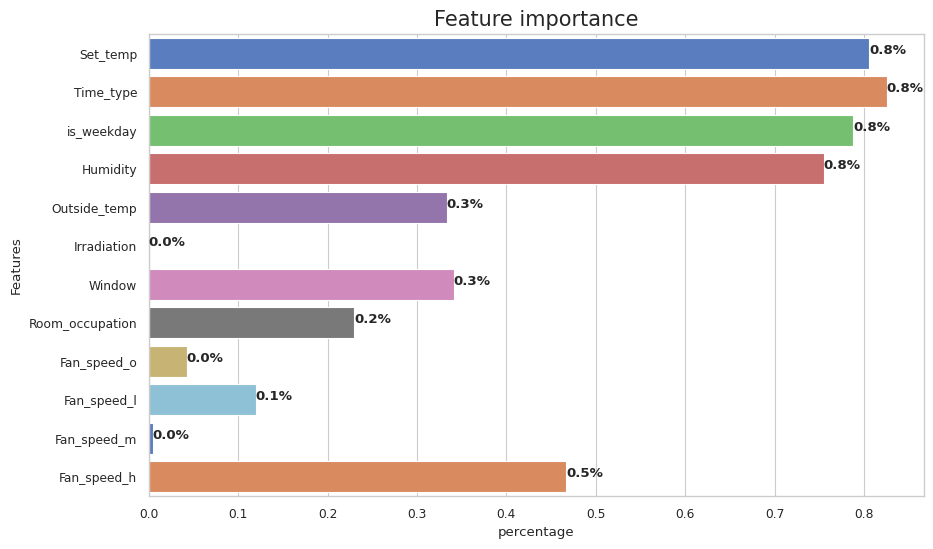

In [84]:
df_sens1 = pd.DataFrame(sens_pie, index=['Set_temp','Time_type', 'is_weekday', 'Humidity', 'Outside_temp', 'Irradiation', 'Window','Room_occupation','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h'])
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=0, y=df_sens1.index, data=df_sens1,  palette="muted",orient='h' )
ax.set_title("Feature importance", fontsize=15)
ax.set_xlabel ("percentage")
ax.set_ylabel ("Features")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

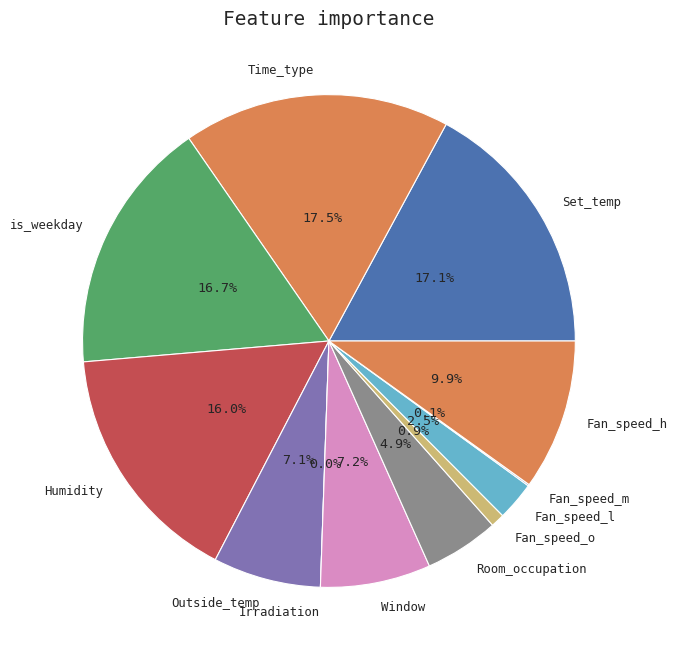

In [ ]:
import matplotlib.pyplot as plt
df_sens1 = df_sens1.rename(columns={0: 'val'})

# Extract the values from the DataFrame column as a 1D array or Series
x = df_sens1['val'].values

labels = ['Set_temp', 'Time_type', 'is_weekday', 'Humidity', 'Outside_temp', 'Irradiation', 'Window', 'Room_occupation', 'Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']

# Create the pie chart using the extracted values
plt.pie(x=x, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Feature importance", fontsize=14)
plt.show()

#Additional Visualizations


##EDA

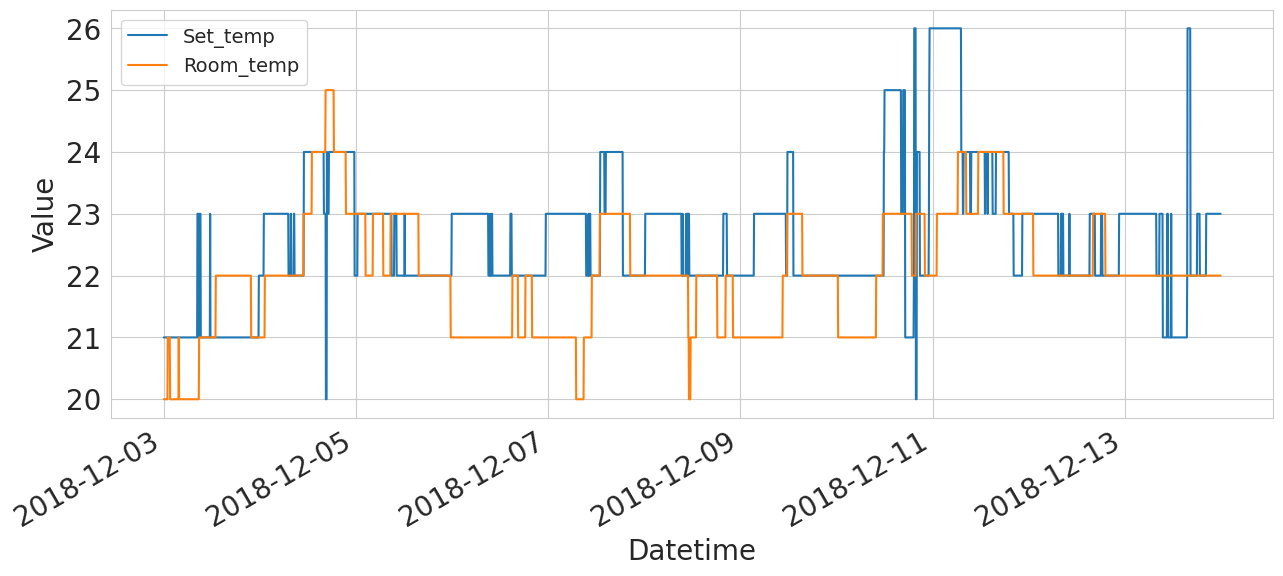

In [ ]:
#Line chart
raw_train = df_raw.loc[(df_raw['Datetime'] >= start) & (df_raw['Datetime'] <= end)]

raw_train=raw_train[['Datetime','Set_temp', 'Room_temp',]]
raw_train=raw_train.set_index('Datetime')

plt.xlabel('Years', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

raw_train['Set_temp'].plot(figsize=(15, 6))
raw_train['Room_temp'].plot(figsize=(15, 6))

plt.legend(fontsize=14)

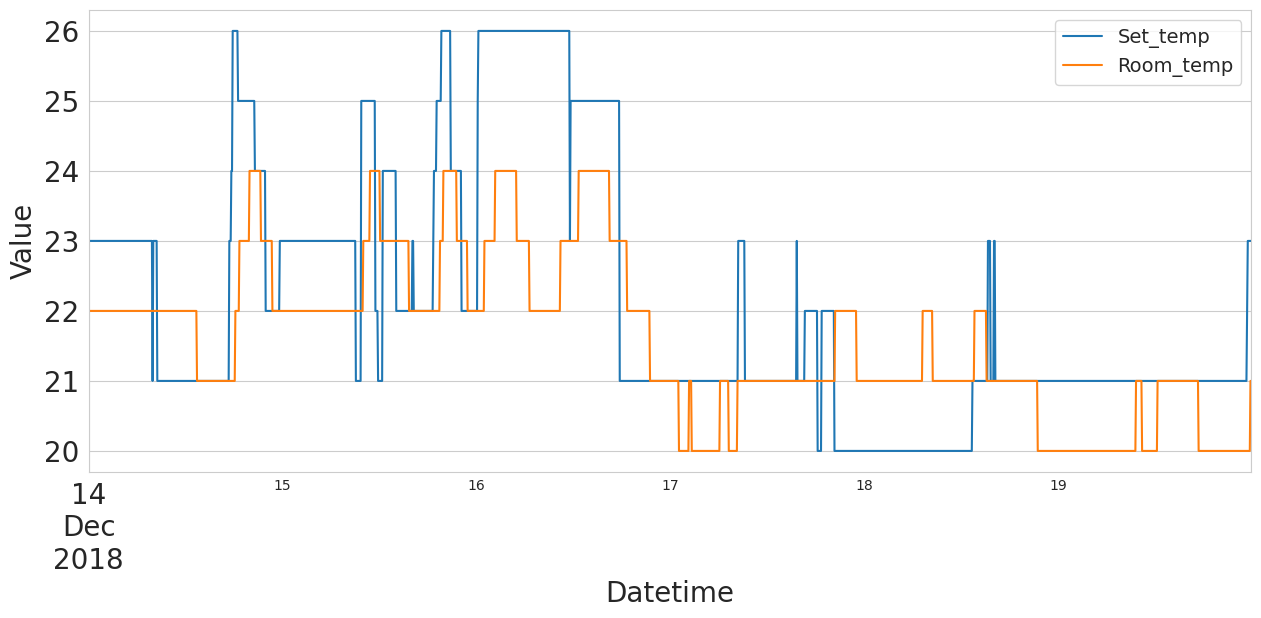

In [ ]:
#Line chart
raw_test = df_raw.loc[(df_raw['Datetime'] >= start_test) & (df_raw['Datetime'] <= end_test)]
raw_test = raw_test.dropna()

raw_test=raw_test[['Datetime','Set_temp', 'Room_temp',]]
raw_test=raw_test.set_index('Datetime')

plt.xlabel('Years', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

raw_test['Set_temp'].plot(figsize=(15, 6))
raw_test['Room_temp'].plot(figsize=(15, 6))

plt.legend(fontsize=14)

<ipython-input-58-cf3dceaaad29>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  raw_train.hist(ax = ax)


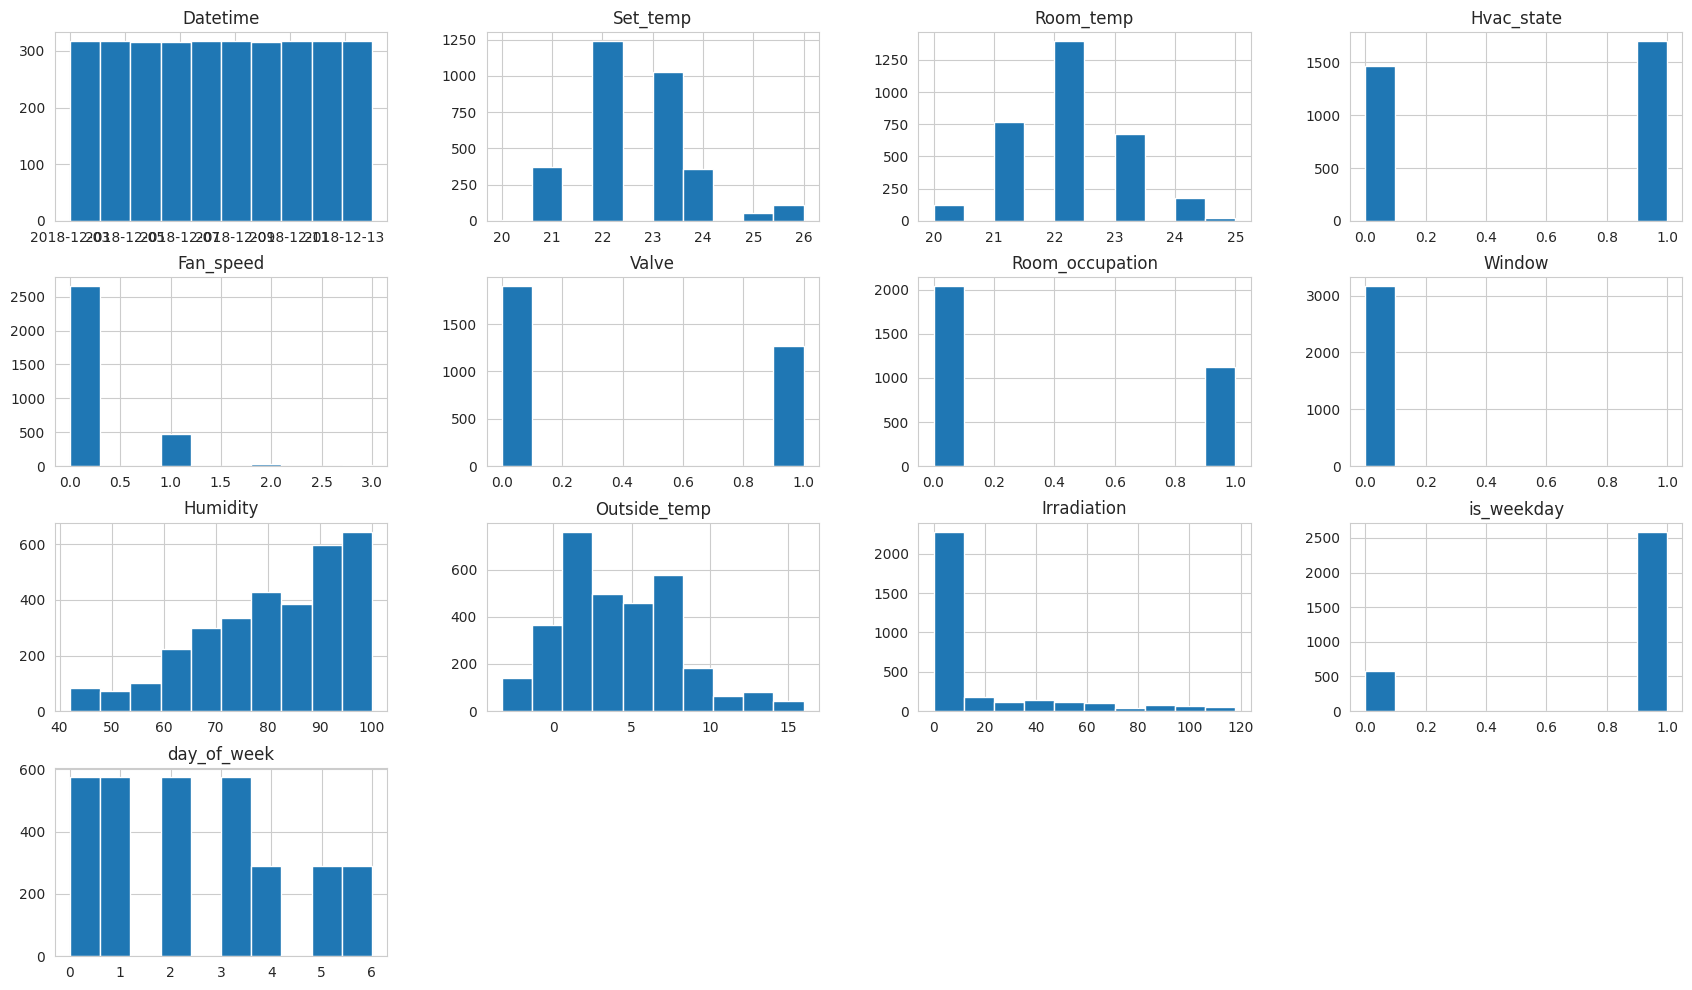

<ipython-input-58-cf3dceaaad29>:14: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  raw_test.hist(ax = ax)


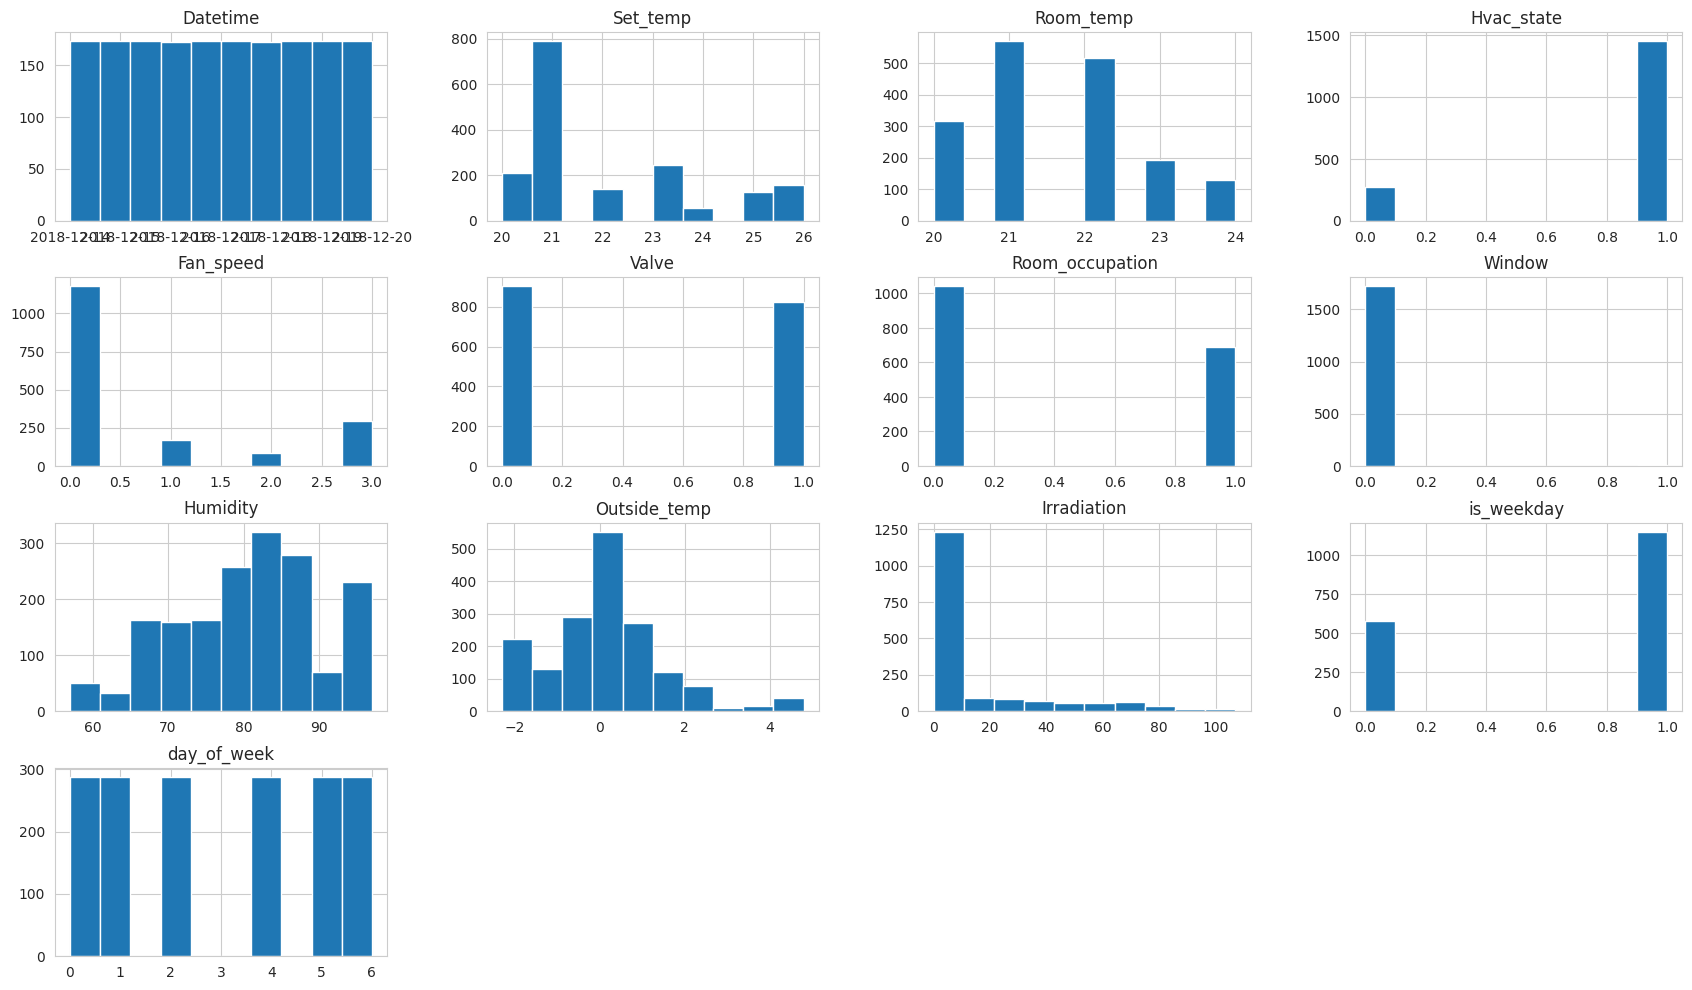

In [ ]:
#DISTRIBUTION
#TRAIN
raw_train = df_raw.loc[(df_raw['Datetime'] >= start) & (df_raw['Datetime'] <= end)]
fig = plt.figure(figsize = (21,12))
ax = fig.gca()
raw_train.hist(ax = ax)
plt.show()


#TEST
raw_test = df_raw.loc[(df_raw['Datetime'] >= start_test) & (df_raw['Datetime'] <= end_test)]
fig = plt.figure(figsize = (21, 12))
ax = fig.gca()
raw_test.hist(ax = ax)
plt.show()

##Feature importance

<Axes: >

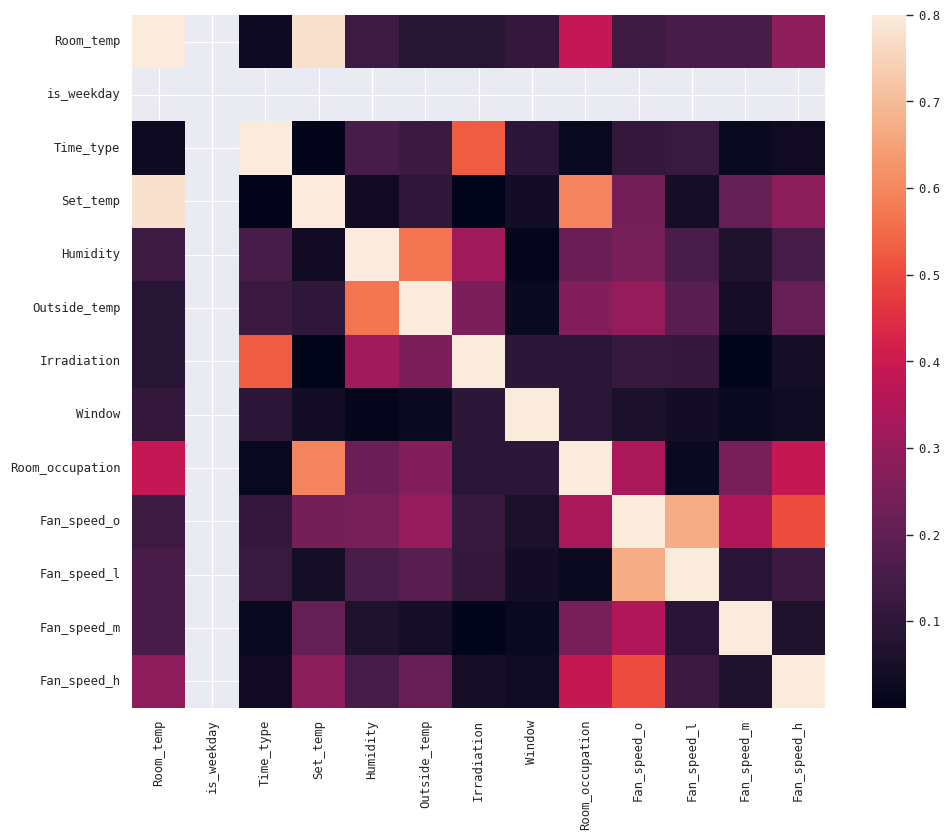

In [ ]:
#Correlation matrix
analyze_df= df[['Room_temp','is_weekday','Time_type','Set_temp',  'Humidity', 'Outside_temp', 'Irradiation', 'Window','Room_occupation','Fan_speed_o', 'Fan_speed_l', 'Fan_speed_m', 'Fan_speed_h']]
corrmat = analyze_df.corr(method='pearson', min_periods=1000)
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = True, yticklabels = True)

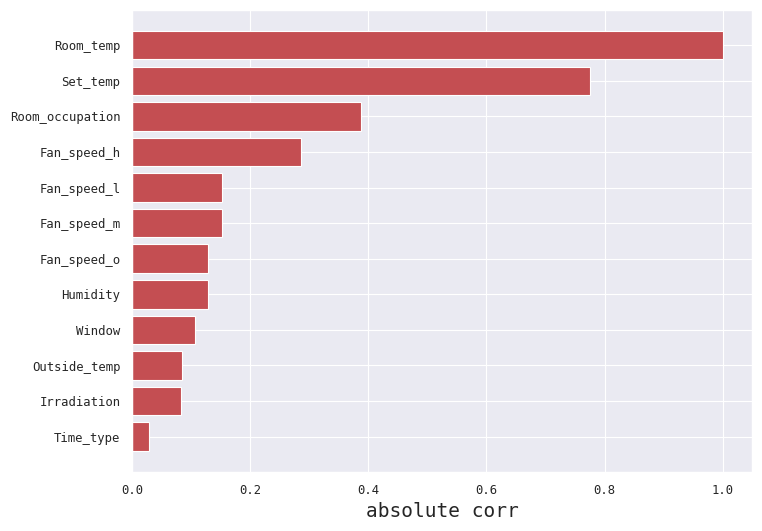

In [ ]:
#Feature importance
remain_num = 50
corr_target = corrmat['Room_temp'].reset_index()
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]

ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,6))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
plt.show()

[11:39:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



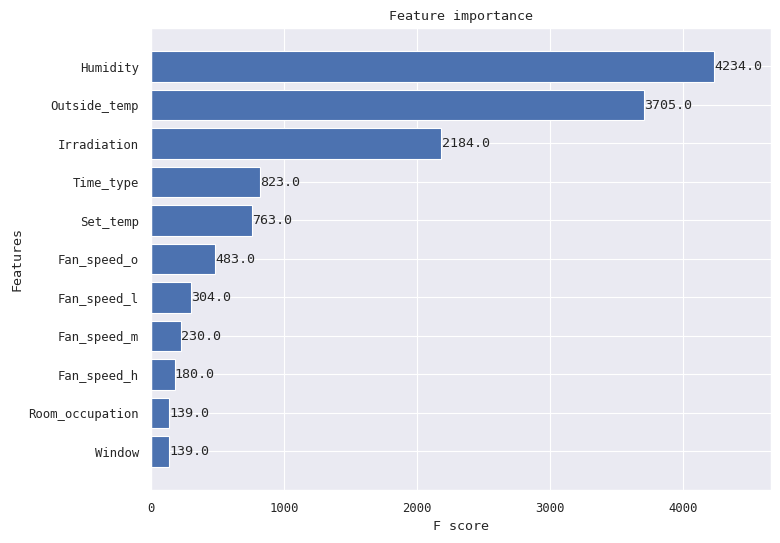

In [ ]:
#XGB model
xgb_train_y = analyze_df.Room_temp.values
xgb_train_X = analyze_df.drop(["Room_temp"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(xgb_train_X, xgb_train_y, feature_names=xgb_train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

fig, ax = plt.subplots(figsize=(8,6))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()